In [ ]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 12.0 MB/s eta 0:00:00


In [ ]:
# Importing required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# Importing DeepXDE library for solving partial differential equations using deep learning
import deepxde as dde

# Importing Scikit-Optimize library for Bayesian hyperparameter optimization
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

In [ ]:


if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
    dy_xxxx = dde.grad.hessian(dy_xx, x,i=0, j=0)

    return dy_t + y * dy_x +0.5 * dy_xxxx

geom = dde.geometry.Interval(0, 10)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: np.sin((3.0/5)*np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=500,  num_boundary=100, num_initial=100,num_test=1000)


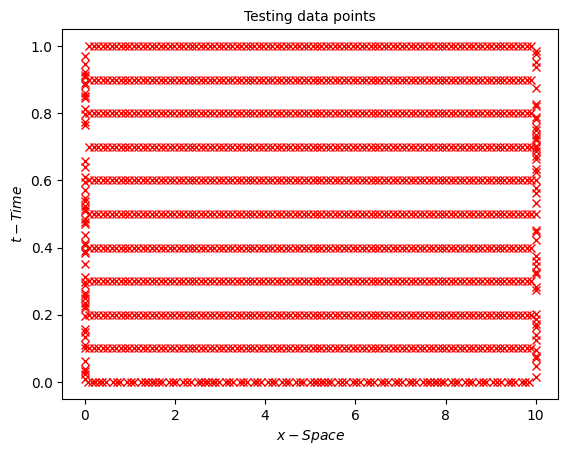

In [ ]:
plt.plot(data.test_points()[:,0],data.test_points()[:,1],'xr',clip_on = False)
plt.xlabel('$x-Space$')
plt.ylabel('$t-Time$')
plt.title('Testing data points', fontsize = 10)
plt.savefig('test_data.eps',dpi=100)


Text(0, 0.5, '$t-time$')

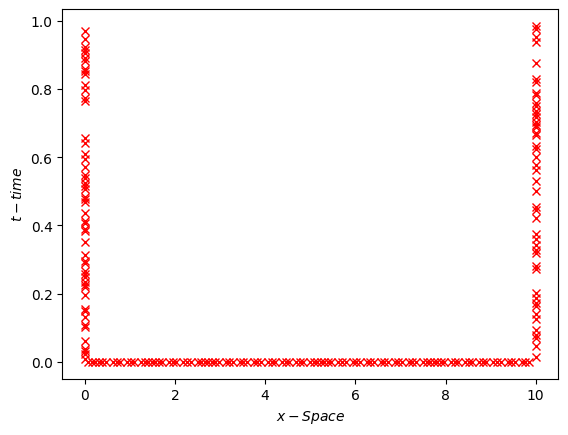

In [ ]:
plt.plot(data.bc_points()[:,0],data.bc_points()[:,1],'xr',clip_on = False)
plt.xlabel('$x-Space$')
plt.ylabel('$t-time$')


In [ ]:
# Find the common elements
common_elements = np.array([x for x in data.train_points() if np.any(np.all(x == data.test_points(), axis=1))])
num_common_elements = common_elements.shape[0]
print("Number of common elements:", num_common_elements)


Number of common elements: 200


Text(0, 0.5, '$t-time$')

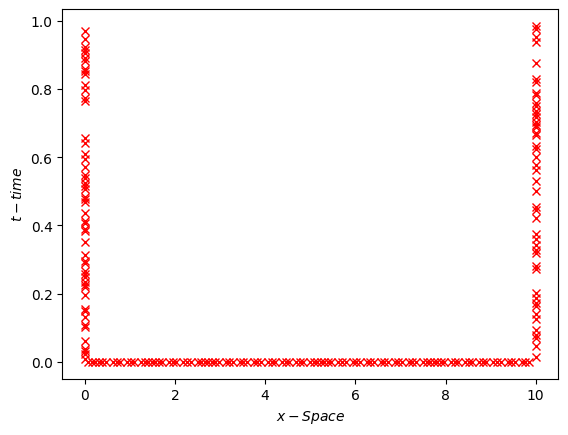

In [ ]:
plt.plot(common_elements[:,0],common_elements[:,1],'xr',clip_on = False)
plt.xlabel('$x-Space$')
plt.ylabel('$t-time$')


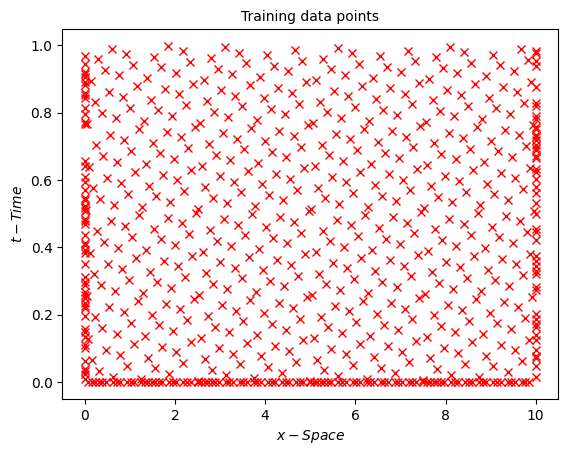

In [ ]:
plt.plot(data.train_points()[:,0],data.train_points()[:,1],'xr',clip_on = False)
plt.xlabel('$x-Space$')
plt.ylabel('$t-Time$')
plt.title('Training data points', fontsize = 10)
plt.savefig('Training_data.eps',dpi=100)


Compiling model...
Building feed-forward neural network...
'build' took 0.128646 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 7.690537 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.79e-02, 2.15e-02, 5.53e-01]    [3.29e-02, 2.15e-02, 5.53e-01]    []  
500       [6.75e-03, 1.12e-02, 4.37e-01]    [5.24e-03, 1.12e-02, 4.37e-01]    []  
1000      [2.85e-02, 2.17e-02, 3.31e-01]    [2.03e-02, 2.17e-02, 3.31e-01]    []  
1500      [3.82e-02, 1.69e-02, 1.38e-01]    [2.11e-02, 1.69e-02, 1.38e-01]    []  
2000      [1.88e-02, 2.47e-03, 2.52e-02]    [1.36e-02, 2.47e-03, 2.52e-02]    []  
2500      [7.09e-03, 5.07e-04, 4.51e-03]    [7.46e-03, 5.07e-04, 4.51e-03]    []  
3000      [4.05e-03, 3.39e-04, 1.54e-03]    [4.76e-03, 3.39e-04, 1.54e-03]    []  
3500      [2.64e-03, 2.49e-04, 8.26e-04]    [3.03e-03, 2.49e-04, 8.26e-04]    []  
4000      [1.82e-03, 1.81e-04, 5.14e-04]    [1.96e-03, 1.81e-04, 5.14e-04]    []  
4500      [1.32e-03, 1.29e-04, 3.34e-04]    [1.38e-03, 1.29e-04, 3.34e-04]    []  
5000      [1.00e-03, 8.57e-05, 2.3

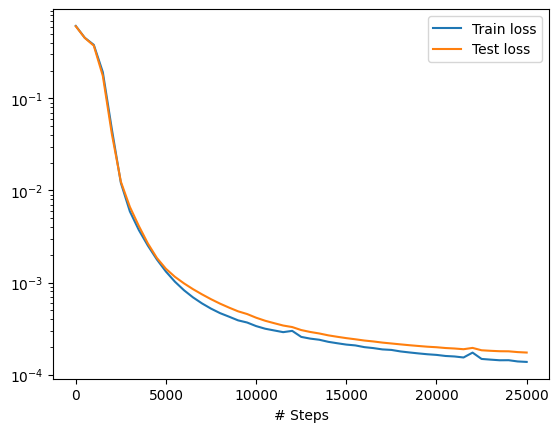

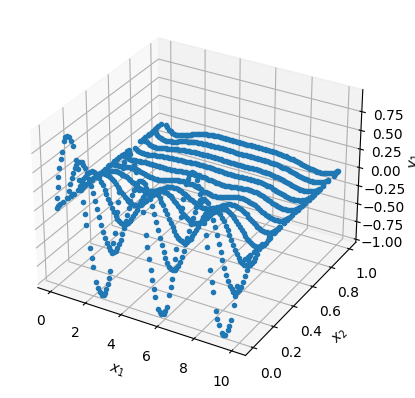

In [ ]:
dde.config.set_random_seed(27)
net = dde.nn.FNN([2] + [16] * 4 + [1], "sin", "Glorot normal")
model = dde.Model(data, net)
model.compile("adam", lr=0.0001416)
losshistory, train_state = model.train(iterations=25000,display_every=500)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspe

In [ ]:
t=np.linspace(0,1,101).reshape(-1,1)
x=np.linspace(0,10,101).reshape(-1,1)


xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T
y_pred = model.predict(X)
f = model.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
#U_pred = griddata(X, y_pred.flatten(), (xx, tt), method='cubic')
U_pred =y_pred.flatten().reshape(101,101) # Predicted solution Over the 2D domain

Mean residual: 0.0070406343
L2 relative error: 1.0358166158792124


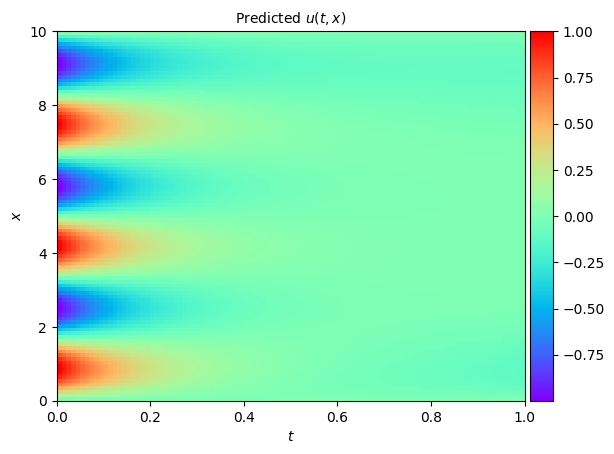

In [ ]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Predicted $u(t,x)$', fontsize = 10)
plt.savefig('u_pred1.eps',dpi=100)

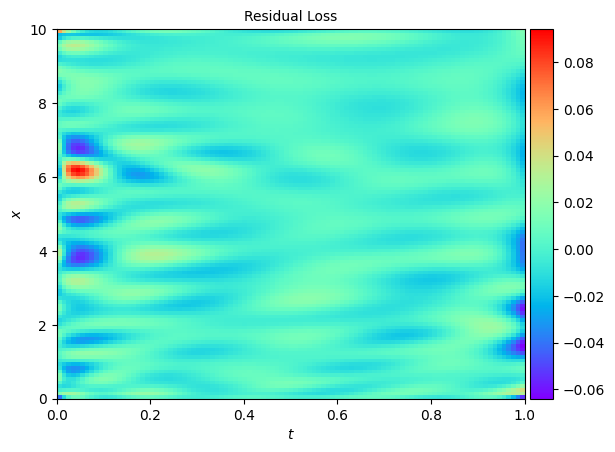

In [ ]:
import matplotlib.gridspec as gridspe
from matplotlib.gridspec import GridSpec
%matplotlib inline
from matplotlib.colors import LogNorm

fig, ax = plt.subplots()
h = ax.imshow(f.reshape(101,101).T, interpolation='nearest', cmap='rainbow',
                  extent=[t.min(), t.max(), x.min(), x.max()],
                  origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)
line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('Residual Loss', fontsize = 10)
plt.savefig('u_resudual.eps',dpi=100)

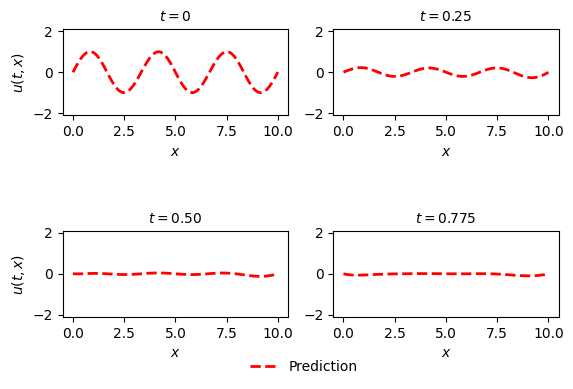

In [ ]:
   ####### u(t,x) slices ##################
fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(x,U_pred[0,:], 'r--', linewidth = 2, label = 'Prediction')
axs[0, 0].set_xlabel('$x$')
axs[0, 0].set_ylabel('$u(t,x)$')
axs[0, 0].set_title('$t = 0$', fontsize = 10)
axs[0, 0].axis('square')
axs[0, 0].set_ylim([-2.1,2.1])

axs[0, 1].plot(x,U_pred[25,:], 'r--', linewidth = 2, label = '')
axs[0, 1].set_xlabel('$x$')
#axs[0, 1].set_ylabel('$u(t,x)$')
axs[0, 1].axis('square')
#ax.set_xlim([-1.1,1.1])
axs[0, 1].set_ylim([-2.1,2.1])
axs[0, 1].set_title('$t = 0.25$', fontsize = 10)
axs[0, 1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)


axs[1, 0].plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
axs[1, 0].set_xlabel('$x$')
axs[1, 0].set_ylabel('$u(t,x)$')
axs[1, 0].axis('square')
#ax.set_xlim([-1.1,1.1])
axs[1, 0].set_ylim([-2.1,2.1])
axs[1, 0].set_title('$t = 0.50$', fontsize = 10)

axs[1, 1].plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
axs[1, 1].set_xlabel('$x$')
axs[1, 1].axis('square')
#ax.set_xlim([-1.1,1.1])
axs[1, 1].set_ylim([-2.1,2.1])
axs[1, 1].set_title('$t = 0.775$', fontsize = 10)
axs[1, 1].legend(loc='upper center', bbox_to_anchor=(-0.13, -0.35), ncol=5, frameon=False)
plt.savefig('u_slice31.eps')